# AIS Dataset Exploration

In [187]:
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely.geometry
from shapely import wkt
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

import ee
ee.Initialize()

## Load in data

In [65]:
data_dir = '/home/k3blu3/datasets/cerulean'
ais_name = '19_ais'
model_name = '19_coincidence'
slick_name = '19_vectors'

In [66]:
ais_files = glob(os.path.join(os.path.join(data_dir, ais_name), '*'))
model_files = glob(os.path.join(os.path.join(data_dir, model_name), '*'))
slick_files = glob(os.path.join(os.path.join(data_dir, slick_name), '*'))

In [67]:
ais = pd.DataFrame(ais_files)
model = pd.DataFrame(model_files)
slick = pd.DataFrame(slick_files)

In [71]:
ais = ais.rename(columns={0: 'fname'})
model = model.rename(columns={0: 'fname'})
slick = slick.rename(columns={0: 'fname'})

In [72]:
ais['basename'] = ais['fname'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
model['basename'] = model['fname'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])
slick['basename'] = slick['fname'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

In [73]:
ais = ais.drop_duplicates(subset=['basename'])

In [74]:
df = ais.merge(model, on='basename', suffixes=('_ais', '_model')).merge(slick, on='basename')
df = df.rename(columns={'fname': 'fname_slick'})
df = df[['basename', 'fname_ais', 'fname_model', 'fname_slick']]

In [75]:
df

,basename,fname_ais,fname_model,fname_slick
0,S1A_IW_GRDH_1SDV_20210107T211923_20210107T2119...,/home/k3blu3/datasets/cerulean/19_ais/S1A_IW_G...,/home/k3blu3/datasets/cerulean/19_coincidence/...,/home/k3blu3/datasets/cerulean/19_vectors/S1A_...
1,S1B_IW_GRDH_1SDV_20201025T164846_20201025T1649...,/home/k3blu3/datasets/cerulean/19_ais/S1B_IW_G...,/home/k3blu3/datasets/cerulean/19_coincidence/...,/home/k3blu3/datasets/cerulean/19_vectors/S1B_...
2,S1A_IW_GRDH_1SDV_20200905T110703_20200905T1107...,/home/k3blu3/datasets/cerulean/19_ais/S1A_IW_G...,/home/k3blu3/datasets/cerulean/19_coincidence/...,/home/k3blu3/datasets/cerulean/19_vectors/S1A_...
3,S1A_IW_GRDH_1SDV_20210906T224044_20210906T2241...,/home/k3blu3/datasets/cerulean/19_ais/S1A_IW_G...,/home/k3blu3/datasets/cerulean/19_coincidence/...,/home/k3blu3/datasets/cerulean/19_vectors/S1A_...
4,S1A_IW_GRDH_1SDV_20220112T213459_20220112T2135...,/home/k3blu3/datasets/cerulean/19_ais/S1A_IW_G...,/home/k3blu3/datasets/cerulean/19_coincidence/...,/home/k3blu3/datasets/cerulean/19_vectors/S1A_...
...,...,...,...,...
191,S1A_IW_GRDH_1SDV_20210419T134630_20210419T1347...,/home/k3blu3/datasets/cerulean/19_ais/S1A_IW_G...,/home/k3blu3/datasets/cerulean/19_coincidence/...,/home/k3blu3/datasets/cerulean/19_vectors/S1A_...
192,S1A_IW_GRDH_1SDV_20220127T111731_20220127T1117...,/home/k3blu3/datasets/cerulean/19_ais/S1A_IW_G...,/home/k3blu3/datasets/cerulean/19_coincidence/...,/home/k3blu3/datasets/cerulean/19_vectors/S1A_...
193,S1A_IW_GRDH_1SDV_20220227T052317_20220227T0523...,/home/k3blu3/datasets/cerulean/19_ais/S1A_IW_G...,/home/k3blu3/datasets/cerulean/19_coincidence/...,/home/k3blu3/datasets/cerulean/19_vectors/S1A_...
194,S1A_IW_GRDH_1SDV_20210305T183416_20210305T1834...,/home/k3blu3/datasets/cerulean/19_ais/S1A_IW_G...,/home/k3blu3/datasets/cerulean/19_coincidence/...,/home/k3blu3/datasets/cerulean/19_vectors/S1A_...


In [77]:
len(df)

196

## Look at some data

In [452]:
row = df.iloc[17]
basename = row.basename

if row.fname_ais.endswith('geojson'):
    gdf_ais = gpd.read_file(row.fname_ais)
else:
    df_ais = pd.read_csv(row.fname_ais)
    df_ais['geometry'] = df_ais['geometry'].apply(wkt.loads)
    gdf_ais = gpd.GeoDataFrame(df_ais, crs='EPSG:4326')
    
gdf_slick = gpd.read_file(row.fname_slick)
df_model = pd.read_csv(row.fname_model)

In [453]:
gdf_ais_lines = list()
for ssvid, group in gdf_ais.groupby('ssvid'):
    if len(group) > 1:
        ls = shapely.geometry.LineString(group.geometry.tolist())
    else:
        ls = group.iloc[0].geometry
    
    entry = dict()
    entry['ssvid'] = ssvid
    entry['geometry'] = ls
    gdf_ais_lines.append(entry)

gdf_ais_lines = gpd.GeoDataFrame(gdf_ais_lines, crs='EPSG:4326')

/tmp/ipykernel_816163/3823998650.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_slick.buffer(0.001).plot(ax=ax, color='black')


<Axes: title={'center': 'S1A_IW_GRDH_1SDV_20220411T064531_20220411T064556_042722_051926_F445'}>

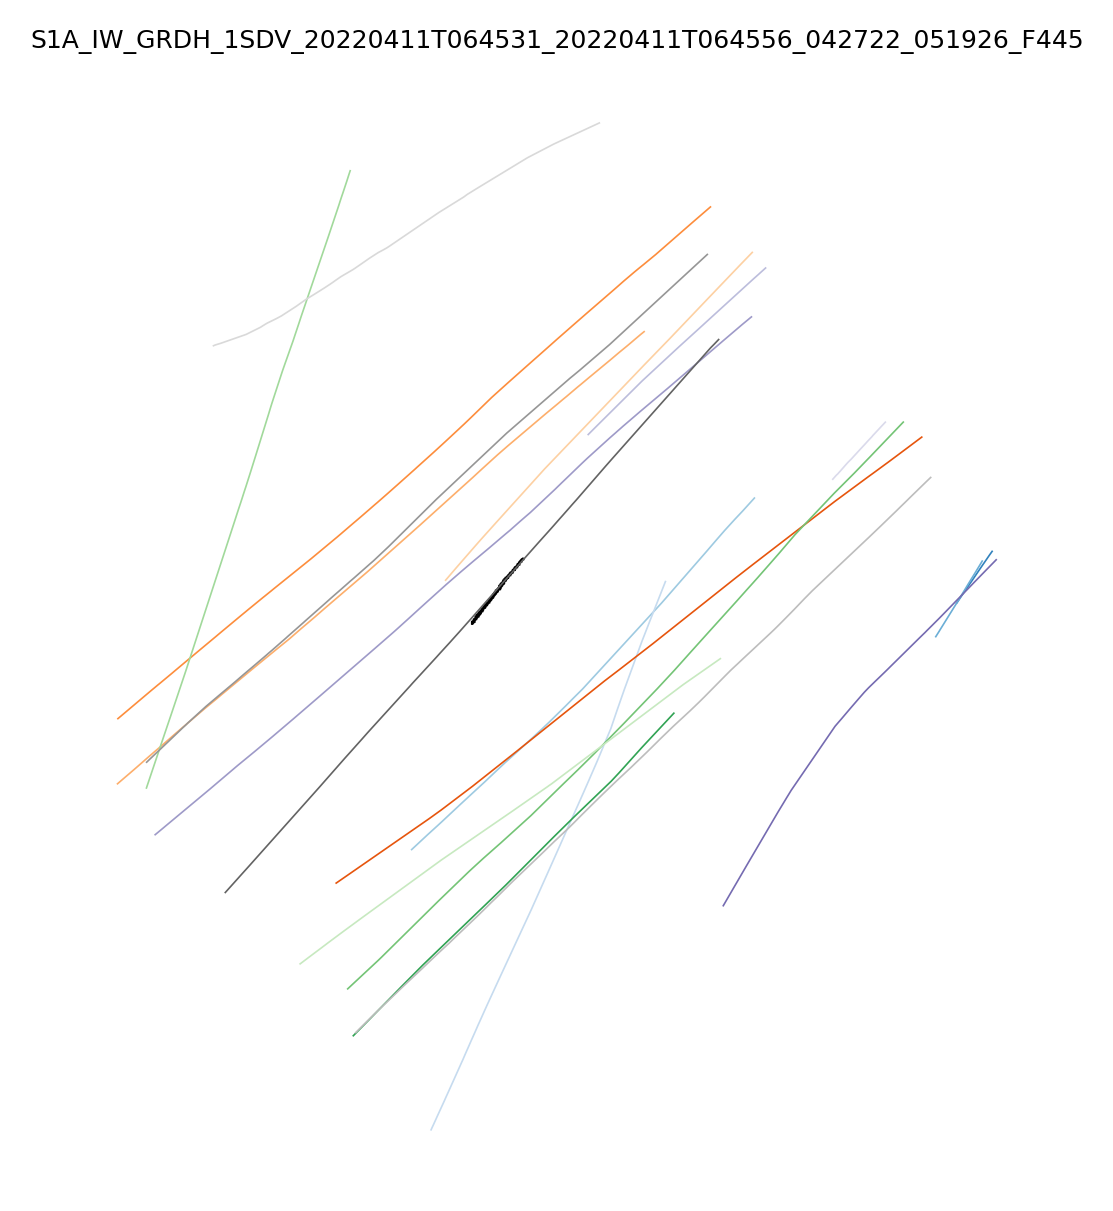

In [454]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)
plt.axis('off')
plt.title(basename, fontsize=6)
gdf_ais_lines.plot(column='ssvid', cmap='tab20c', ax=ax, linewidth=0.4, markersize=0.4)
gdf_slick.buffer(0.001).plot(ax=ax, color='black')

In [173]:
s1_id = 'COPERNICUS/S1_GRD'
img = ee.Image(f"{s1_id}/{basename}")